In [2]:
import cv2
import numpy as np
import os
import glob
 
# Defining the dimensions of checkerboard
CHECKERBOARD = (10,7)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = [] 
 
 
# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None
 
# Extracting path of individual image stored in a given directory
images = glob.glob('fotos_calibracion/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
     
    """
    If desired number of corner are detected,
    we refine the pixel coordinates and display 
    them on the images of checker board
    """
    if ret == True:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
         
        imgpoints.append(corners2)
 
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
     
    cv2.imshow('img',img)
    cv2.waitKey(0)
 
cv2.destroyAllWindows()
 
h,w = img.shape[:2]
 
"""
Performing camera calibration by 
passing the value of known 3D points (objpoints)
and corresponding pixel coordinates of the 
detected corners (imgpoints)
"""
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
 
print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)

Camera matrix : 

[[3.00531985e+03 0.00000000e+00 1.50110026e+03]
 [0.00000000e+00 3.02966117e+03 1.95589345e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 

[[ 2.22677505e-01 -1.01592677e+00  3.45712226e-03 -5.76337243e-04
   1.45200958e+00]]
rvecs : 

(array([[ 0.21638702],
       [-0.40694597],
       [-0.1811603 ]]), array([[0.23730952],
       [0.59035356],
       [0.12720262]]), array([[0.29506645],
       [0.43486592],
       [0.06908512]]), array([[0.29741042],
       [0.05132197],
       [0.00164868]]), array([[ 0.30029569],
       [-0.32222505],
       [-0.0837029 ]]), array([[ 0.25985819],
       [-0.54281695],
       [-0.12791837]]))
tvecs : 

(array([[-3.32095613],
       [-5.65485677],
       [13.21388183]]), array([[-4.67674635],
       [-7.08867264],
       [15.18250302]]), array([[-4.79386237],
       [-7.12870259],
       [14.94867586]]), array([[-4.90046037],
       [-6.06419424],
       [12.60331013]]), array([[-3.14784701],
       [-4.72711904],
     

In [29]:
# Extracting the focal lengths and principal point coordinates from the camera matrix
fx = mtx[0, 0]
fy = mtx[1, 1]
cx = mtx[0, 2]
cy = mtx[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")

fx: 3005.3198508884184, fy: 3029.6611662458745, cx: 1501.100259943101, cy: 1955.893454931007


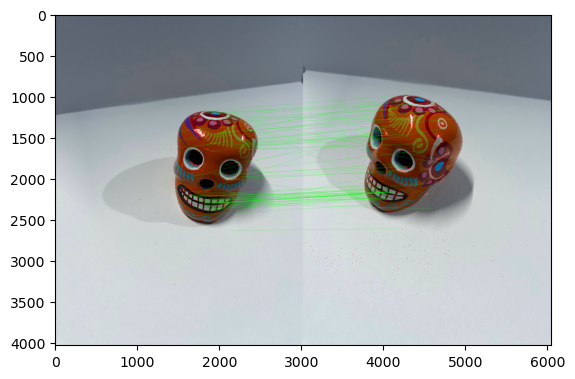

The maximum number of function evaluations is exceeded.
Function evaluations 600, initial cost 1.6405e+10, final cost 1.5190e+10, first-order optimality 2.57e+07.
PLY file written to point_cloud.ply


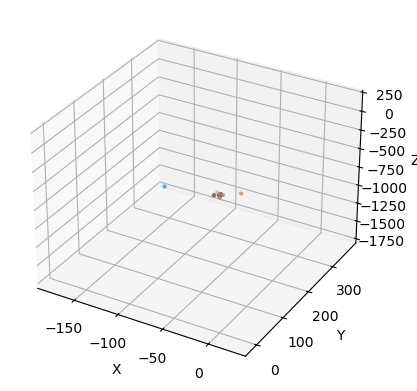

In [4]:
"""
Estructura desde movimiento
Implementación incial.

Se debe completar las siguientes funcionalidades:
- Extracción y correspondencia de carcaterísticas
- Generar imágen de las correspondencias

JCA
"""

import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


# Ruta a imágenes
PATH_IM1 = 'fotos_calibracion/foto1.jpg'
PATH_IM2 = 'fotos_calibracion/foto2.jpg'
# Número de puntos claves
# Equivalente a número de puntos a reconstruir
NO_KPT = 1000

# Poner los parámetris intrínsecos del celular
# Calculado con la calibración de la cámara
FX = 3005.3198508884184
FY = 3029.6611662458745
CX = 1501.100259943101
CY = 1955.893454931007


##### FUNCIONES #####
# Función de optimización
def bundle_adjustment(points_3D, pts1, pts2, K, R, t):
    """ Realiza la optimización conjunta de puntos 3D, y parámetros extrínsecos.
        Con la reducción de error de re-proyección cuadrático
    """
    def project_points(points_3D, R, t):
        """Proyecta los puntos reconstruídos con K: matriz intrínseca
            y con la matriz extrínseca [R | T] 
        """
        points_3D_h = np.hstack((points_3D, np.ones((points_3D.shape[0], 1))))
        P = K @ np.hstack((R, t))
        projected_2D = (P @ points_3D_h.T).T
        projected_2D /= projected_2D[:, 2:3]
        return projected_2D[:, :2]

    def reprojection_error(params, points_3D, pts1, pts2, K):
        """Calcula el error de re-proyección"""
        rvec = params[:3]
        tvec = params[3:6]
        points_3D = points_3D.reshape(-1, 3)

        R, _ = cv2.Rodrigues(rvec)
        t = tvec.reshape(3, 1)

        projected_pts1 = project_points(points_3D, np.eye(3), np.zeros((3, 1)))
        projected_pts2 = project_points(points_3D, R, t)

        error_1 = (pts1 - projected_pts1).ravel()
        error_2 = (pts2 - projected_pts2).ravel()

        return np.hstack((error_1, error_2))

    rvec, _ = cv2.Rodrigues(R)
    initial_params = np.hstack((rvec.ravel(), t.ravel()))

    result = least_squares(reprojection_error, initial_params, verbose=1,
                           args=(points_3D, pts1, pts2, K))

    optimized_rvec = result.x[:3]
    optimized_t = result.x[3:6]
    optimized_R, _ = cv2.Rodrigues(optimized_rvec)

    return points_3D, optimized_R, optimized_t

def export_ply(filename, points_3D, colors):
    """Exporta en formato PLY para visualización en Blender
    """
    assert points_3D.shape[0] == colors.shape[0], "Points and colors must have the same number of entries"
    
    # Open file to write
    with open(filename, 'w') as file:
        # Write PLY header
        file.write("ply\n")
        file.write("format ascii 1.0\n")
        file.write(f"element vertex {len(points_3D)}\n")
        file.write("property float x\n")
        file.write("property float y\n")
        file.write("property float z\n")
        file.write("property uchar red\n")
        file.write("property uchar green\n")
        file.write("property uchar blue\n")
        file.write("end_header\n")

        # Write the points and colors
        for point, color in zip(points_3D, colors):
            r, g, b = (color * 255).astype(int)
            file.write(f"{point[0]} {point[1]} {point[2]} {r} {g} {b}\n")
    
    print(f"PLY file written to {filename}")



# Cargar imágenes
img1 = cv2.imread(PATH_IM1)
img2 = cv2.imread(PATH_IM2)

# Matriz con parámetros intrínsecos
K = np.array([[FX, 0, CX], [0, FY, CY], [0, 0, 1]])  

######## COMPLETAR ########
# Extracción y correspondencia de características
# Identificar puntos claves
# Dibujar imágen con la correspondencia de puntos claves
# Initiate SIFT detector
sift = cv2.SIFT_create()

# encontrar los puntos clave y descriptores con SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
des1 = np.asarray(des1, np.float32)
des2 = np.asarray(des2, np.float32)
search_params = dict(checks=50) 
FLANN_INDEX_LSH = 4
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)


matchesMask = [[0,0] for i in range(len(matches))]

for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
 singlePointColor = (255,0,0),
 matchesMask = matchesMask,
 flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

########################

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Acá se debe generar la imágen de la correspondecia
# Luego de dejar solo los puntos "buenos"


# Obtener los colores de los puntos claves
colors = []
for match in good_matches:
    pt1 = kp1[match.queryIdx].pt
    color1 = img1[int(pt1[1]), int(pt1[0])] / 255.0
    colors.append(color1)

# Matriz Esencial entre las dos imágenes
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=0.5)  # Reduced threshold

_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K, mask=mask)

# Triangulación de puntos
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = np.hstack((R, t))

P1 = K @ P1
P2 = K @ P2

points_4D = cv2.triangulatePoints(P1, P2, pts1, pts2)
points_3D = points_4D / points_4D[3]  # Convert from homogeneous to Cartesian coordinates
points_3D = points_3D[:3, :].T
points_3D, optimized_R, optimized_t = bundle_adjustment(points_3D, pts1, pts2, K, R, t)

points_3D = np.array(points_3D)
colors = np.array(colors)
# Guardar en formato PLY
# Para visualizar en Blender u otro software 3D
export_ply('point_cloud.ply', points_3D, colors)
import matplotlib.pyplot as plt
points_3D = np.vstack(points_3D)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='o', s=5, c=colors, alpha=0.5)

# Configure the plot

# # Configure the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()